# Advanced Machine Learning - June 2023 Exam

Andrea LA ROSA

<andrea.larosa6@studio.unibo.it>

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.stats import randint, uniform, norm
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import GridSearchCV
from keras.models import load_model
from keras.callbacks import History
from keras.layers import Dropout
import pickle

Warning: in this notebook KerasRegressor was used, which is deprecated. However for the reasons of convenience (sorry!) it has not been replaced with Sci-Keras within this project.

# Exercise 1

## Data Import

In [ ]:
# If you use Google Colab, it may be useful to run this cell
# to download the necessary files from a GitHub repository.

!git clone https://github.com/andrealrs/Heston-Model-adaGrid.git

folder_path = "Heston-Model-adaGrid/"

fatal: destination path 'Heston-Model-adaGrid' already exists and is not an empty directory.


In [ ]:
# Otherwise, if you use VS Code, Jupyter, or similar,
# you can skip the download step, since the necessary
# files are already in the local directory.

folder_path = ""

In [ ]:
inputs = folder_path+"inputs/"
outputs = folder_path+"outputs/"

In [ ]:
# Import the training data
data_train = np.loadtxt(inputs+"Heston_samples_adaGrid_train.txt")

# Extract input features (Heston parameters)
X_train = data_train[:, :5]

# Extract output labels (implied volatilities)
y_train = data_train[:, 5:]

In [ ]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train shape:  (32645, 5)
y_train shape:  (32645, 88)


In [ ]:
def X_summary(X):
  # Compute statistics
  mean = np.mean(X, axis=0)
  std = np.std(X, axis=0)
  minimum = np.min(X, axis=0)
  maximum = np.max(X, axis=0)
  median = np.median(X, axis=0)
  variance = np.var(X, axis=0)

  # Create a DataFrame for the summary table
  summary_table = pd.DataFrame({
      "Minimum": minimum.round(4),
      "Maximum": maximum.round(4),
      "Median": median.round(4),
      "Mean": mean.round(4),
      "Standard Deviation": std.round(4),
      "Variance": variance.round(4)
  })

  # Set the parameters as the index of the table
  parameters = ["kappa", "theta", "eta", "v0", "rho"]
  summary_table.index = parameters

  return summary_table

In [ ]:
print(X_summary(X_train))

       Minimum  Maximum  Median    Mean  Standard Deviation  Variance
kappa     2.00      6.0  4.0011  4.0008              1.1546    1.3330
theta     0.01      0.2  0.1053  0.1052              0.0547    0.0030
eta       1.00      2.5  1.7490  1.7495              0.4330    0.1875
v0        0.01      0.2  0.1054  0.1053              0.0547    0.0030
rho      -0.90     -0.5 -0.6992 -0.6994              0.1152    0.0133


In [ ]:
# Import the test data and extract the X and y
data_test  = np.loadtxt(inputs+"Heston_samples_adaGrid_test.txt")
X_test = data_test[:, :5]
y_test = data_test[:, 5:]

In [ ]:
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_test shape:  (1022, 5)
y_test shape:  (1022, 88)


In [ ]:
print(X_summary(X_test))

       Minimum  Maximum  Median    Mean  Standard Deviation  Variance
kappa   2.0010   5.9995  4.0027  4.0009              1.1556    1.3355
theta   0.0102   0.1999  0.1053  0.1052              0.0548    0.0030
eta     1.0015   2.5000  1.7492  1.7495              0.4333    0.1877
v0      0.0100   0.1999  0.1051  0.1052              0.0548    0.0030
rho    -0.8998  -0.5000 -0.6997 -0.6997              0.1153    0.0133


In [ ]:
# Define the scalers
X_std_scaler = StandardScaler()
y_std_scaler = StandardScaler()

X_MinMax_scaler = MinMaxScaler()
y_MinMax_scaler = MinMaxScaler()

# Apply the scalers to the training and test data
X_train_std_scaled = X_std_scaler.fit_transform(X_train)
y_train_std_scaled = y_std_scaler.fit_transform(y_train)
X_test_std_scaled = X_std_scaler.transform(X_test)
y_test_std_scaled = y_std_scaler.fit_transform(y_test)

X_train_MinMax_scaled = X_MinMax_scaler.fit_transform(X_train)
y_train_MinMax_scaled = y_MinMax_scaler.fit_transform(y_train)
X_test_MinMax_scaled = X_MinMax_scaler.transform(X_test)

## Hyper parameters tuning

### Random Search

In [ ]:
def std_build_model(hp):
    # Define the hyperparameters space
    N_hiddenLayers = hp.Int("num_layers", 3, 4, step=1)
    N_nodes = hp.Int("num_nodes", 200, 400, step=50)
    initializer = hp.Choice("initializer", ["glorot_uniform", "he_uniform", "uniform"])
    dropout_rate = hp.Float("dropout_rate", 0, 0.2, step=0.1, default=0)
    batch_size = hp.Choice("batch_size", [256, 512, 1024])
    epochs = hp.Int("epochs", 200, 500, step=50)
    activation = hp.Choice("activation", ["relu", "sigmoid", "swish"])
    use_batch_norm = hp.Boolean("use_batch_norm", default=False)

    # Build the model architecture
    i = tf.keras.layers.Input(shape=(5,))
    x = tf.keras.layers.Dense(N_nodes, activation=activation, kernel_initializer=initializer)(i)
    
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    
    c = 0
    while c < N_hiddenLayers:
        x = tf.keras.layers.Dense(N_nodes, activation=activation, kernel_initializer=initializer)(x)
        
        if use_batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        c += 1
    x = tf.keras.layers.Dense(88, activation="linear")(x)

    model = tf.keras.models.Model(inputs=i, outputs=x)

    # Compile the model
    model.compile(loss="mse", optimizer="adam")

    # Define early stopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=20)

    # Train the model with early stopping
    model.fit(X_train_std_scaled, y_train_std_scaled, epochs=epochs, batch_size=batch_size,
              validation_split=0.2, verbose=1, callbacks=[early_stopping])

    return model

std_tuner = RandomSearch(
    std_build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="RandomSearch",
    project_name="StandardScaler-Val-Loss"
)

std_tuner.search_space_summary()

std_tuner.search(X_train_std_scaled, y_train_std_scaled, validation_split=0.2, verbose=1)

# Capture and export the results summary
std_tuner.results_summary()

old_stdout = sys.stdout
result_file = open(outputs+"RandomSearch-std-val-loss-results.txt", "w")
sys.stdout = result_file
std_tuner.results_summary()
result_file.close()
sys.stdout = old_stdout

# Save the best model and its weights
best_model_std = std_tuner.get_best_models(num_models=1)[0]
best_model_std.save(outputs+"RandomSearch-std-val-loss-best-model.h5")
best_model_std.save_weights(outputs+"RandomSearch-std-val-loss-best-model-weights.h5")

In [ ]:
def MinMax_build_model(hp):
    # Get the hyperparameters
    N_hiddenLayers = hp.Int("num_layers", 3, 4, step=1)
    N_nodes = hp.Int("num_nodes", 200, 400, step=50)
    initializer = hp.Choice("initializer", ["glorot_uniform", "he_uniform", "uniform"])
    dropout_rate = hp.Float("dropout_rate", 0, 0.2, step=0.1, default=0)
    batch_size = hp.Choice("batch_size", [256, 512, 1024])
    epochs = hp.Int("epochs", 200, 500, step=50)
    activation = hp.Choice("activation", ["relu", "sigmoid", "swish"])
    use_batch_norm = hp.Boolean("use_batch_norm", default=False)

    # Build the model architecture
    i = tf.keras.layers.Input(shape=(5,))
    x = tf.keras.layers.Dense(N_nodes, activation=activation, kernel_initializer=initializer)(i)
    
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    
    c = 0
    while c < N_hiddenLayers:
        x = tf.keras.layers.Dense(N_nodes, activation=activation, kernel_initializer=initializer)(x)
        
        if use_batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        c += 1
    x = tf.keras.layers.Dense(88, activation="linear")(x)

    model = tf.keras.models.Model(inputs=i, outputs=x)

    # Compile the model
    model.compile(loss="mse", optimizer="adam")

    # Define early stopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=20)

    # Train the model with early stopping
    model.fit(X_train_MinMax_scaled, y_train_MinMax_scaled, epochs=epochs, batch_size=batch_size,
              validation_split=0.2, verbose=1, callbacks=[early_stopping])

    return model

MinMax_tuner = RandomSearch(
    MinMax_build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="RandomSearch",
    project_name="MinMaxScaler-Val-Loss"
)

MinMax_tuner.search_space_summary()

MinMax_tuner.search(X_train_MinMax_scaled, y_train_MinMax_scaled, validation_split=0.2, verbose=1)

# Capture and export the results summary
MinMax_tuner.results_summary()

old_stdout = sys.stdout
result_file = open(outputs+"RandomSearch-minmax-val-loss-results.txt", "w")
sys.stdout = result_file
MinMax_tuner.results_summary()
result_file.close()
sys.stdout = old_stdout

# Save the best model and its weights
best_model_MinMax = tuner.get_best_models(num_models=1)[0]
best_model_MinMax.save(outputs+"RandomSearch-MinMax-val-loss-best-model.h5")
best_model_MinMax.save_weights(outputs+"RandomSearch-MinMax-val-loss-best-model-weights.h5")

### GridSearch

In [ ]:
from keras.callbacks import History

# Define the parameter grid for GridSearchCV
param_grid = {
    "hidden_layer_count": [3, 4],
    "node_count": [200, 300, 350],
    "batch_size": [256, 512, 1024],
}

# Create the model architecture
def create_model(hidden_layer_count, node_count, batch_size):
    i = tf.keras.layers.Input(shape=(5,))
    x = tf.keras.layers.Dense(node_count, activation="swish", kernel_initializer="glorot_uniform")(i)
    c = 0
    while c < hidden_layer_count:
        x = tf.keras.layers.Dense(node_count, activation="swish", kernel_initializer="glorot_uniform")(x)
        c += 1
    x = tf.keras.layers.Dense(88, activation="linear")(x)
    model = tf.keras.models.Model(inputs=i, outputs=x)
    model.compile(loss="mse", optimizer="adam")
    return model

# Create the KerasRegressor
regressor = KerasRegressor(build_fn=create_model, verbose=0)

# Perform grid search
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid,
                           scoring="neg_mean_squared_error", cv=3)

# Fit the grid search to the data
grid_search.fit(X_train_std_scaled, y_train_std_scaled)

# Get the results as a DataFrame
GridSearch_results_df = pd.DataFrame(grid_search.cv_results_)
GridSearch_results_df = GridSearch_results_df.sort_values(by="rank_test_score")

# Save the best model and its weights
GridSearch_best_model = grid_search.best_estimator_.model
GridSearch_best_model.save(outputs+"GridSearch-best-model.h5")
GridSearch_best_model.save_weights(outputs+"GridSearch-best-model-weights.h5")

# Export the results to a CSV file
GridSearch_results_df.to_csv(outputs+"GridSearch-results.csv", index=False)

# Print the rank and MSE for each configuration
GridSearch_ranked_results = GridSearch_results_df[["rank_test_score", "params", "mean_test_score"]]
GridSearch_ranked_results["mean_test_score"] = np.abs(GridSearch_ranked_results["mean_test_score"])  # Convert back to positive MSE
GridSearch_ranked_results.columns = ["Rank", "Parameters", "Mean Squared Error"]
print(GridSearch_ranked_results)

# Get the best model and parameters
GridSearch_best_model = grid_search.best_estimator_
GridSearch_best_params = grid_search.best_params_

# Define early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=20)

# Train the best model with early stopping and save the history
history = GridSearch_best_model.fit(X_train_std_scaled, y_train_std_scaled,
                                    epochs=350, batch_size=GridSearch_best_params["batch_size"],
                                    validation_split=0.2, verbose=1,
                                    callbacks=[early_stopping, History()])

# Save the history to a dictionary
history_dict = history.history

# Save the history dictionary to a file
with open(outputs+"GridSearch-best-model-history.pkl", "wb") as file:
    pickle.dump(history_dict, file)

# Predict with the best model
y_pred_std_scaled = GridSearch_best_model.predict(X_test_std_scaled)
y_pred = y_std_scaler.inverse_transform(y_pred_std_scaled)
np.savetxt(outputs+"y_pred.csv", y_pred, delimiter=",")
np.savetxt(outputs+"y_pred_std_scaled.csv", y_pred_std_scaled, delimiter=",")

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Best Model Mean Squared Error:", mse)
print("Best Model Root Mean Squared Error", np.sqrt(mse))

## Model

In [ ]:
# Load the model
model = load_model(outputs+"GridSearch-best-model.h5")

# Check the model summary
model.summary()

# Load the weights
model.load_weights(outputs+"GridSearch-best-model-weights.h5")

NNWeights = []
for i in range(1, len(model.layers)):
    NNWeights.append(model.layers[i].get_weights())

Model: "model_338"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_339 (InputLayer)      [(None, 5)]               0         
                                                                 
 dense_1852 (Dense)          (None, 350)               2100      
                                                                 
 dense_1853 (Dense)          (None, 350)               122850    
                                                                 
 dropout_1176 (Dropout)      (None, 350)               0         
                                                                 
 dense_1854 (Dense)          (None, 350)               122850    
                                                                 
 dropout_1177 (Dropout)      (None, 350)               0         
                                                                 
 dense_1855 (Dense)          (None, 350)               12

In [ ]:
# Load the saved history dictionary
with open(outputs+"GridSearch-best-model-history.pkl", "rb") as file:
    history_dict = pickle.load(file)

# Access the metrics from the history dictionary
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

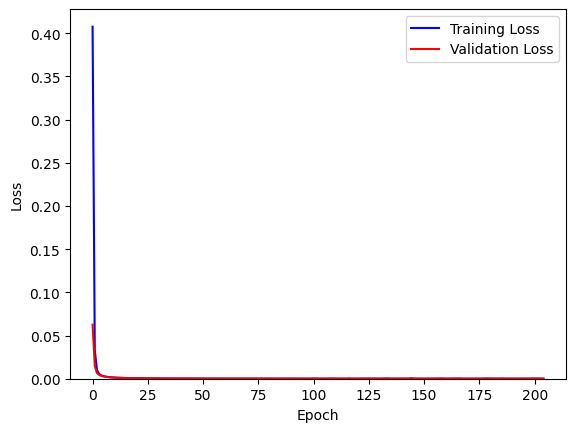

In [ ]:
plt.plot(loss_values, "b", label="Training Loss")
plt.plot(val_loss_values, "r", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0)  # Set the y-axis limits to restrict up to 0.1
plt.savefig(folder_path+"plots/loss-plot.jpg", format="jpg", dpi=300)

plt.show()

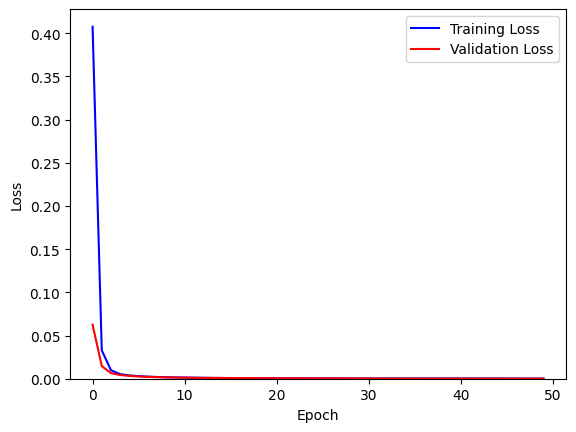

In [ ]:
plt.plot(loss_values[:50], "b", label="Training Loss")
plt.plot(val_loss_values[:50], "r", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0)  # Set the y-axis limits to restrict up to 0.1
plt.savefig(folder_path+"plots/loss-plot-50epochs.jpg", format="jpg", dpi=300)

plt.show()

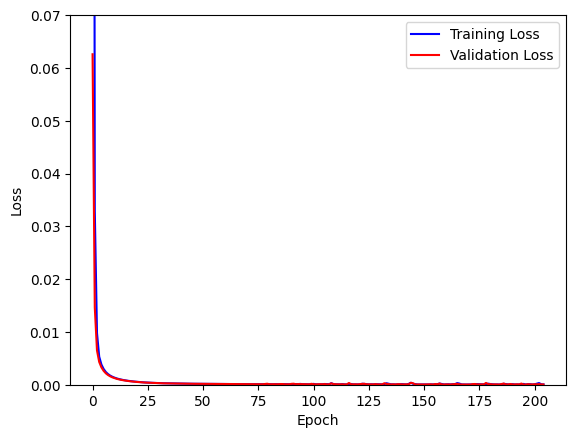

In [ ]:
plt.plot(loss_values, "b", label="Training Loss")
plt.plot(val_loss_values, "r", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0, 0.07)  # Set the y-axis limits to restrict up to 0.1
plt.savefig(folder_path+"plots/loss-plot-ylim.jpg", format="jpg", dpi=300)

plt.show()

In [ ]:
y_pred = np.loadtxt(outputs+"y_pred.csv", delimiter=",")
y_pred_std_scaled = np.loadtxt(outputs+"y_pred_std_scaled.csv", delimiter=",")

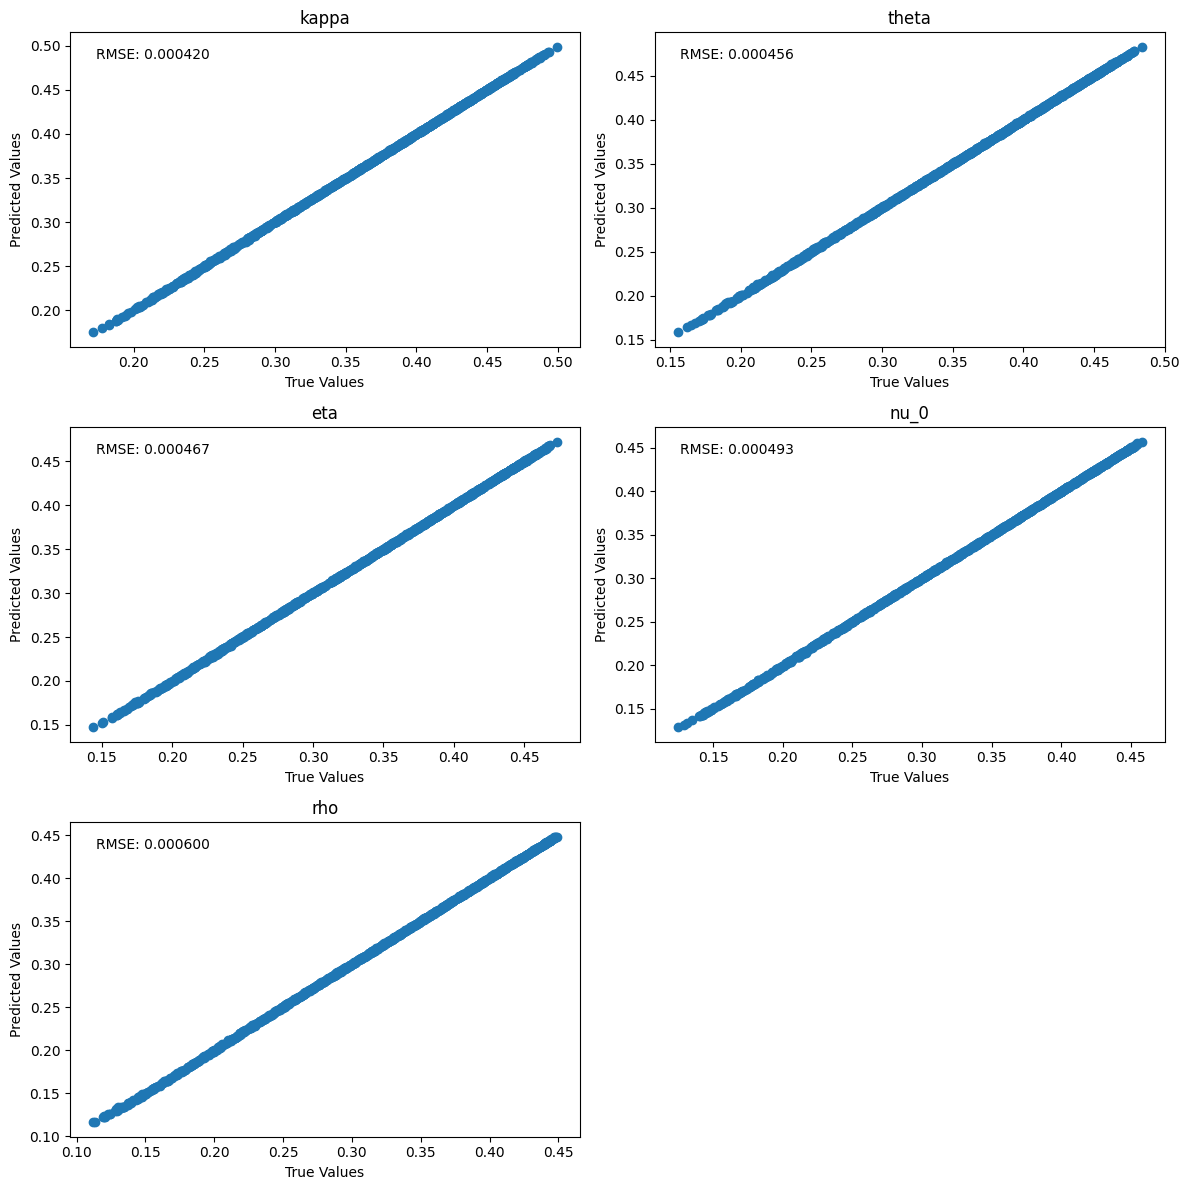

In [ ]:
num_samples, num_targets = y_test.shape

selected_targets = [0, 1, 2, 3, 4]
target_names = ["kappa", "theta", "eta", "nu_0", "rho"]


num_rows = len(selected_targets) // 2 + len(selected_targets) % 2
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 4*num_rows))

for i, target_idx in enumerate(selected_targets):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.scatter(y_test[:, target_idx], y_pred[:, target_idx])
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f"{target_names[target_idx]}")
    
    # Calculate MSE, RMSE, and R-squared for the target variable
    mse = mean_squared_error(y_test[:, target_idx], y_pred[:, target_idx])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[:, target_idx], y_pred[:, target_idx])
    
    # Annotate the plot with metric values
    ax.text(0.05, 0.95, f"RMSE: {rmse:.6f}",
            transform=ax.transAxes, verticalalignment="top")

# Remove the last subplot if there is an odd number of selected targets
if len(selected_targets) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.savefig(folder_path+"plots/pred-vs-true-plot.jpg", format="jpg", dpi=300)
plt.show()

## Calibrate to the volatility surface

If we have dropout layers in our neural network, the *NNWeights* list will not include the weights and biases associated with those dropout layers. Dropout layers do not have trainable weights or biases because their purpose is to randomly deactivate neurons during training.

To handle the *NNWeights* list correctly when using a model with dropout layers, in fact, we need to ensure that we are extracting the weights and biases from the non-dropout layers only.

In [ ]:
NNWeights2 = []
layer_index = 0
for layer in model.layers:
    if isinstance(layer, Dropout):
        continue  # Skip dropout layers
    weights = layer.get_weights()
    if len(weights) > 0:
        NNWeights2.append(weights)
    layer_index += 1

In [ ]:
NumLayers = 4 # Hidden Layers + 1

def swish(x):
    return x/(np.exp(-x)+1)

def swishPrime(x):
    return (np.exp(-x)+1+x*np.exp(-x))/((np.exp(-x)+1)**2)

def NN_Fun(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNWeights2[i][0])+NNWeights2[i][1]
        input1=swish(input1)
    #The output layer is linear
    i+=1
    return np.dot(input1,NNWeights2[i][0])+NNWeights2[i][1]

def NN_Grad(x):
    input1=x
    # Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(5)
    # Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNWeights2[i][0])+NNWeights2[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNWeights2[i][0]))
        #Elu activation
        grad*=swishPrime (input1)
        input1=swish(input1)
    grad=np.einsum('ij,jk->ik',grad,NNWeights2[i+1][0])
    # Grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

In [ ]:
bounds = (X_std_scaler.transform([[2.00, 0.01, 1.00, 0.01, -0.90]])[0][:5], 
          X_std_scaler.transform([[6.00, 0.20, 2.50, 0.20, -0.50]])[0][:5])
bounds = [(lower, upper) for lower, upper in zip(*bounds)]

init = []
for bound in bounds:
    init.append(0.5*(bound[0]+bound[1]))

In [ ]:
def CostFunc(params, target):
    return np.sum(np.power((NN_Fun(params)-target), 2))
def Jacobian(params, target):
    return 2*np.sum((NN_Fun(params)-target)*NN_Grad(params), axis=1)

In [ ]:
# Load the market data from mktData_adaGrid.txt
mkt_data = np.loadtxt(inputs+"mktData_adaGrid.txt")

In [ ]:
mkt_data_reshaped = mkt_data.reshape(-1,1)
scaler = StandardScaler()
scaler.fit(mkt_data_reshaped)
mkt_data_reshaped_scaled = scaler.transform(mkt_data_reshaped)
mkt_data_scaled = mkt_data_reshaped_scaled.reshape(mkt_data.shape)

In [ ]:
import time
import scipy
start = time.time()        
res = scipy.optimize.minimize(lambda x: CostFunc(x, mkt_data_scaled), x0=init, 
                              method='L-BFGS-B', jac=lambda x: Jacobian(x, mkt_data_scaled), bounds=bounds, 
                              tol=1E-10, options={"maxiter":5000})
stop = time.time()

print('elapsed: ' + str(stop-start))

# Obtain calibrated parameters
rescaled_x = X_std_scaler.inverse_transform(res.x.reshape(1, -1))
optm_params = rescaled_x[0][:5]

print('optm params: ' + str(optm_params))

fval = res.fun
print('fval: ' + str(fval))

# Calculate calibrated volatilities using the calibrated parameters
calibrated_volatilities = NN_Fun(res.x)

# Assess the fit by comparing calibrated volatilities with market data
error = calibrated_volatilities - mkt_data
rmse = np.sqrt(np.mean(error**2))

print("RMSE:", rmse)

elapsed: 0.1293778419494629
optm params: [ 2.          0.16332104  2.5         0.10906919 -0.9       ]
fval: 20.9501157776415
RMSE: 0.6732777548442588


In [ ]:
start = time.time()        
res = scipy.optimize.minimize(lambda x: CostFunc(x, mkt_data), x0=init, 
                              method='L-BFGS-B', jac=lambda x: Jacobian(x, mkt_data), bounds=bounds, 
                              tol=1E-10, options={"maxiter":5000})
stop = time.time()

print('elapsed: ' + str(stop-start))

# Obtain calibrated parameters
rescaled_x = X_std_scaler.inverse_transform(res.x.reshape(1, -1))
optm_params = rescaled_x[0][:5]

print('optm params: ' + str(optm_params))

fval = res.fun
print('fval: ' + str(fval))

# Calculate calibrated volatilities using the calibrated parameters
calibrated_volatilities = NN_Fun(res.x)

# Assess the fit by comparing calibrated volatilities with market data
error = calibrated_volatilities - mkt_data
rmse = np.sqrt(np.mean(error**2))

print("RMSE:", rmse)

elapsed: 0.2345411777496338
optm params: [ 3.89858975  0.11234387  2.04087527  0.10887857 -0.66204988]
fval: 0.09390640659635272
RMSE: 0.032666776038916594


# Exercise 2 - Inverse Map

## Inverse Map - Data preparation

In [253]:
# Extract input features (implied volatilities)
X_inv_train = data_train[:, 5:]

# Extract output labels (Heston parameters)
y_inv_train = data_train[:, :5]

print("X_inv_train shape:", X_inv_train.shape)
print("y_inv_train shape:", y_inv_train.shape)

X_inv_train shape: (32645, 88)
y_inv_train shape: (32645, 5)


In [ ]:
# Extract the X and y of test data
X_inv_test = data_test[:, 5:]
y_inv_test = data_test[:, :5]

print("X_inv_test shape:", X_inv_test.shape)
print("y_inv_test shape:", y_inv_test.shape)

X_inv_test shape: (1022, 88)
y_inv_test shape: (1022, 5)


In [ ]:
# Define the scalers
X_inv_std_scaler = StandardScaler()
y_inv_std_scaler = StandardScaler()

# Apply the scalers to the training and test data
X_inv_train_scaled = X_inv_std_scaler.fit_transform(X_inv_train)
y_inv_train_scaled = y_inv_std_scaler.fit_transform(y_inv_train)
X_inv_test_scaled = X_inv_std_scaler.transform(X_inv_test)
y_inv_test_scaled = y_inv_std_scaler.fit_transform(y_inv_test)

## Inverse Map - GridSearch

In [ ]:
from keras.callbacks import History

# Define the parameter grid for GridSearchCV (InverseMap)
param_grid = {
    "hidden_layer_count": [3, 4],
    "node_count": [200, 300, 350, 400],
    "batch_size": [256, 512, 1024],
    "dropout_rate": [0.0, 0.1, 0.2]
}

# Create the model architecture
def create_inv_model(hidden_layer_count, node_count, batch_size, dropout_rate):
    i = tf.keras.layers.Input(shape=(88,))
    x = tf.keras.layers.Dense(node_count, activation="swish", kernel_initializer="glorot_uniform")(i)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    c = 0
    while c < hidden_layer_count:
        x = tf.keras.layers.Dense(node_count, activation="swish", kernel_initializer="glorot_uniform")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        c += 1
    x = tf.keras.layers.Dense(5, activation="linear")(x)
    model = tf.keras.models.Model(inputs=i, outputs=x)
    model.compile(loss="mse", optimizer="adam")
    return model

# Create the KerasRegressor
regressor_inv = KerasRegressor(build_fn=create_inv_model, verbose=0)

# Perform grid search
grid_search_inv = GridSearchCV(estimator=regressor_inv, param_grid=param_grid,
                               scoring="neg_mean_squared_error", cv=3)

# Fit the grid search to the data
grid_search_inv.fit(X_inv_train_scaled, y_inv_train_scaled)

# Get the results as a DataFrame
GridSearch_inv_results_df = pd.DataFrame(grid_search_inv.cv_results_)
GridSearch_inv_results_df = GridSearch_inv_results_df.sort_values(by="rank_test_score")

# Save the best model and its weights
GridSearch_inv_best_model = grid_search_inv.best_estimator_.model
GridSearch_inv_best_model.save(outputs+"GridSearch-inv-best-model.h5")
GridSearch_inv_best_model.save_weights(outputs+"GridSearch-inv-best-model-weights.h5")

# Export the results to a CSV file
GridSearch_inv_results_df.to_csv(outputs+"GridSearch-inv-results.csv", index=False)

# Print the rank and MSE for each configuration
GridSearch_inv_ranked_results = GridSearch_inv_results_df[["rank_test_score", "params", "mean_test_score"]]
GridSearch_inv_ranked_results["mean_test_score"] = np.abs(GridSearch_inv_ranked_results["mean_test_score"])  # Convert back to positive MSE
GridSearch_inv_ranked_results.columns = ["Rank", "Parameters", "Mean Squared Error"]
print(GridSearch_inv_ranked_results)

# Get the best model and parameters
GridSearch_inv_best_model = grid_search_inv.best_estimator_
GridSearch_inv_best_params = grid_search_inv.best_params_

# Define early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=20)

# Train the best model with early stopping and save the history
history_inv = GridSearch_inv_best_model.fit(X_inv_train_scaled, y_inv_train_scaled,
                                            epochs=350, batch_size=GridSearch_inv_best_params["batch_size"],
                                            validation_split=0.2, verbose=1,
                                            callbacks=[early_stopping, History()])

# Save the history to a dictionary
history_inv_dict = history_inv.history

# Save the history dictionary to a file
with open(outputs+"GridSearch-inv-best-model-history.pkl", "wb") as file:
    pickle.dump(history_inv_dict, file)

# Calculate MSE
mse_inv = mean_squared_error(y_inv_test, y_inv_pred)
print("Best Model Mean Squared Error:", mse_inv)
print("Best Model Root Mean Squared Error:", np.sqrt(mse_inv))

<ipython-input-312-0c78277b8bba>:27: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor_inv = KerasRegressor(build_fn=create_inv_model, verbose=0)
<ipython-input-312-0c78277b8bba>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GridSearch_inv_ranked_results["mean_test_score"] = np.abs(GridSearch_inv_ranked_results["mean_test_score"])  # Convert back to positive MSE


    Rank                                         Parameters  \
7      1  {'batch_size': 256, 'dropout_rate': 0.0, 'hidd...   
1      2  {'batch_size': 256, 'dropout_rate': 0.0, 'hidd...   
6      3  {'batch_size': 256, 'dropout_rate': 0.0, 'hidd...   
21     4  {'batch_size': 256, 'dropout_rate': 0.2, 'hidd...   
10     5  {'batch_size': 256, 'dropout_rate': 0.1, 'hidd...   
..   ...                                                ...   
48    68  {'batch_size': 1024, 'dropout_rate': 0.0, 'hid...   
64    69  {'batch_size': 1024, 'dropout_rate': 0.2, 'hid...   
52    70  {'batch_size': 1024, 'dropout_rate': 0.0, 'hid...   
60    71  {'batch_size': 1024, 'dropout_rate': 0.1, 'hid...   
68    72  {'batch_size': 1024, 'dropout_rate': 0.2, 'hid...   

    Mean Squared Error  
7             0.014192  
1             0.015115  
6             0.017648  
21            0.023302  
10            0.023884  
..                 ...  
48            0.265940  
64            0.286492  
52            0.32

## Inverse Map - Model

In [ ]:
from keras.callbacks import EarlyStopping, History

hidden_layer_count = 4
node_count = 400
batch_size = 256
dropout_rate = 0.0

# Create the model architecture
def create_model():
    i = tf.keras.layers.Input(shape=(88,))
    x = tf.keras.layers.Dense(node_count, activation="swish", kernel_initializer="glorot_uniform")(i)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    c = 0
    while c < hidden_layer_count:
        x = tf.keras.layers.Dense(node_count, activation="swish", kernel_initializer="glorot_uniform")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        c += 1
    x = tf.keras.layers.Dense(5, activation="linear")(x)
    model = tf.keras.models.Model(inputs=i, outputs=x)
    model.compile(loss="mse", optimizer="adam")
    return model

# Create the model
model = create_model()

# Define early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=100)

# Train the model with early stopping and save the history
history = model.fit(X_inv_train_scaled, y_inv_train_scaled,
                    epochs=500, batch_size=batch_size,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stopping, History()])

# Save the model and its weights
model.save(outputs+"GridSearch-inv-best-model.h5")
model.save_weights(outputs+"GridSearch-inv-best-model-weights.h5")

# Save the history to a dictionary
history_dict = history.history

# Save the history dictionary to a file
with open(outputs+"GridSearch-inv-best-model-history.pkl", "wb") as file:
    pickle.dump(history_dict, file)

# Predict with the best model
y_inv_pred_scaled = model.predict(X_inv_test)
np.savetxt("y_inv_pred_scaled.csv", y_inv_pred, delimiter=",")

# Calculate MSE
mse_inv = mean_squared_error(y_inv_test, y_inv_pred)
print("Best Model Mean Squared Error:", mse_inv)
print("Best Model Root Mean Squared Error:", np.sqrt(mse_inv))


Epoch 1/500
103/103 [==============================] - 8s 58ms/step - loss: 0.1288 - val_loss: 0.0077
Epoch 2/500
103/103 [==============================] - 9s 83ms/step - loss: 0.0062 - val_loss: 0.0042
Epoch 3/500
103/103 [==============================] - 8s 74ms/step - loss: 0.0044 - val_loss: 0.0064
Epoch 4/500
103/103 [==============================] - 8s 82ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 5/500
103/103 [==============================] - 8s 83ms/step - loss: 0.0025 - val_loss: 0.0292
Epoch 6/500
103/103 [==============================] - 8s 78ms/step - loss: 0.0066 - val_loss: 0.0033
Epoch 7/500
103/103 [==============================] - 8s 76ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 8/500
103/103 [==============================] - 4s 35ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 9/500
103/103 [==============================] - 4s 36ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 10/500
103/103 [==============================] - 5s 51ms/step - loss: 8.785

In [ ]:
# Load the model
model_inv = load_model(outputs+"GridSearch-inv-best-model.h5")

# Check the model summary
model_inv.summary()

# Load the weights
model_inv.load_weights(outputs+"GridSearch-inv-best-model-weights.h5")

NNWeights_inv = []
for i in range(1, len(model_inv.layers)):
    NNWeights_inv.append(model_inv.layers[i].get_weights())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 88)]              0         
                                                                 
 dense_18 (Dense)            (None, 400)               35600     
                                                                 
 dropout_15 (Dropout)        (None, 400)               0         
                                                                 
 dense_19 (Dense)            (None, 400)               160400    
                                                                 
 dropout_16 (Dropout)        (None, 400)               0         
                                                                 
 dense_20 (Dense)            (None, 400)               160400    
                                                                 
 dropout_17 (Dropout)        (None, 400)               0   

In [ ]:
# Load the saved history dictionary
with open(outputs+"GridSearch-inv-best-model-history.pkl", "rb") as file:
    history_inv_dict = pickle.load(file)

# Access the metrics from the history dictionary
loss_values_inv = history_inv_dict["loss"]
val_loss_values_inv = history_inv_dict["val_loss"]

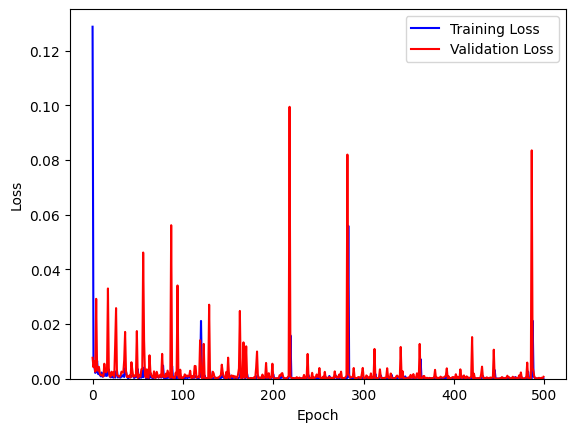

In [ ]:
plt.plot(loss_values_inv, "b", label="Training Loss")
plt.plot(val_loss_values_inv, "r", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0)  # Set the y-axis limits to restrict up to 0.1
plt.savefig(folder_path+"plots/loss-inv-plot.jpg", format="jpg", dpi=300)

plt.show()

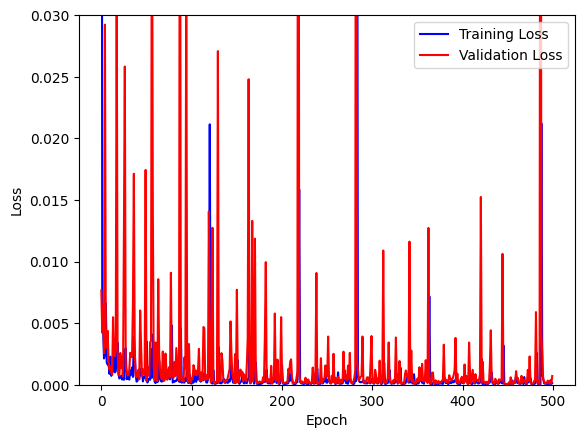

In [ ]:
plt.plot(loss_values_inv, "b", label="Training Loss")
plt.plot(val_loss_values_inv, "r", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,0.03)  # Set the y-axis limits to restrict up to 0.1
plt.savefig(folder_path+"plots/loss-inv-ylim-plot.jpg", format="jpg", dpi=300)

plt.show()

## Inverse Map - Predicted vs True parameters

In [ ]:
y_inv_pred_scaled = np.loadtxt(outputs+"y_inv_pred_scaled.csv", delimiter=",")

In [ ]:
# Make predictions on the test data
predicted_params = y_inv_pred_scaled

# Compare the predicted parameters with the true parameters (from unseen_data)
true_params = y_inv_test_scaled

# Calculate mean squared error (MSE) as a measure of performance
mse_inv = np.mean((predicted_params - true_params) ** 2)
print("Mean Squared Error (MSE):", mse_inv)


Mean Squared Error (MSE): 0.9353216197318152


In [ ]:
# Unscaled the true_params and predicted_params
true_params_unscaled = y_inv_std_scaler.inverse_transform(true_params)
predicted_params_unscaled = y_inv_std_scaler.inverse_transform(predicted_params)
np.savetxt(outputs+"y_inv_pred.csv", predicted_params_unscaled, delimiter=",")

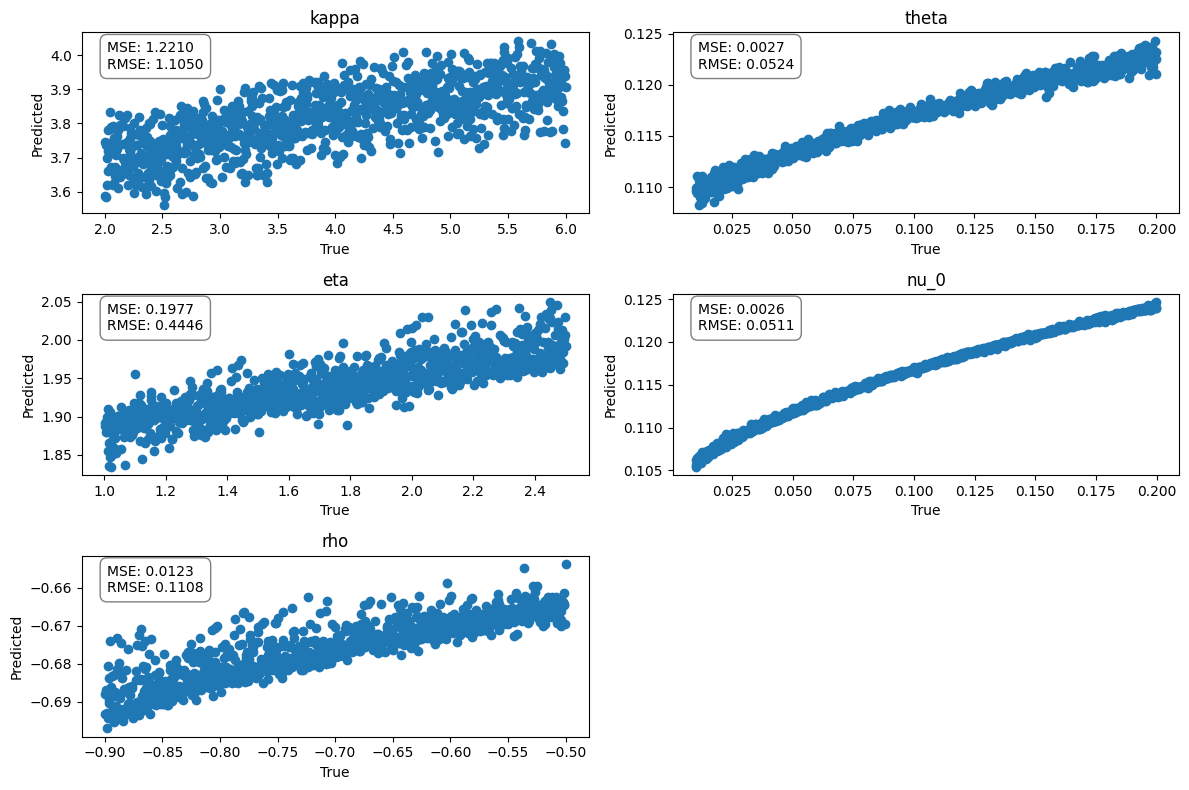

In [ ]:
# List of parameter names
parameters = ["kappa", "theta", "eta", "nu_0", "rho"]

# Calculate the number of parameters
num_params = predicted_params_unscaled.shape[1]

# Determine the number of rows and columns for the grid
num_rows = (num_params - 1) // 2 + 1
num_cols = 2

# Create the grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot predicted_params vs true_params for each parameter
for i, ax in enumerate(axes):
    # Skip the 6th parameter (that does not exist)
    if i == 5:
        ax.axis("off")
        continue

    # Calculate MSE and RMSE for the parameter
    mse = np.mean((true_params_unscaled[:, i] - predicted_params_unscaled[:, i]) ** 2)
    rmse = np.sqrt(mse)

    ax.scatter(true_params_unscaled[:, i], predicted_params_unscaled[:, i])
    ax.text(0.05, 0.95, f"MSE: {mse:.4f}\nRMSE: {rmse:.4f}", transform=ax.transAxes, va="top", ha="left", bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.set_title(f"{parameters[i]}")

# Adjust the spacing between subplots
fig.tight_layout()

plt.savefig(folder_path+"plots/inverse-map-true-vs-predicted.jpg", format="jpg", dpi=300)
plt.show()


## Inverse Map - Option princing

In [ ]:
# Define in a simple way the Heston model
def heston_model(S0, r, kappa, theta, eta, rho, T, K):
    dt = 1 / 252  # Assume daily time steps
    N = int(T / dt)
    sqrt_dt = np.sqrt(dt)

    # Initialize arrays
    V = np.zeros(N)
    S = np.zeros(N)
    S[0] = S0

    for i in range(1, N):
        # Generate two correlated random variables
        Z1 = np.random.standard_normal()
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.standard_normal()

        # Euler scheme for variance process
        V[i] = np.maximum(V[i-1] + kappa * (theta - V[i-1]) * dt + eta * np.sqrt(V[i-1]) * sqrt_dt * Z2, 0)

        # Euler scheme for stock price process
        S[i] = S[i-1] * np.exp((r - 0.5 * V[i]) * dt + np.sqrt(V[i]) * sqrt_dt * Z1)

    # Calculate option prices using the Heston model
    option_prices = np.maximum(S[-1] - K, 0)  # European call option payoff

    # Discount option prices back to present value
    discounted_option_prices = option_prices * np.exp(-r * T)

    return np.mean(discounted_option_prices)

In [ ]:
# Load the calibrated parameters obtained from the neural network
kappa_calibrated = optm_params[0]
theta_calibrated = optm_params[1]
eta_calibrated = optm_params[2]
v0_calibrated = optm_params[3]
rho_calibrated = optm_params[4]

In [ ]:
# Load the grid specifications (see meta_adaGrid.py)
tFwVarCurve = [0.0000, 0.0100, 0.0250, 0.1000, 0.3000, 0.6000, 1.0000, 1.5000, 2.0000]
tGrid = [0.01, 0.025, 0.1, 0.3, 0.6, 1.0, 1.5, 2.0]
kGrid = [[0.9450, 0.9600, 0.9700, 0.9840, 0.9920, 1.0000, 1.0050, 1.0100, 1.0150, 1.0200, 1.0300],
         [0.9130, 0.9350, 0.9550, 0.9750, 0.9900, 1.0000, 1.0100, 1.0200, 1.0300, 1.0380, 1.0470],
         [0.8260, 0.8700, 0.9200, 0.9500, 0.9800, 1.0000, 1.0200, 1.0400, 1.0600, 1.0800, 1.0950],
         [0.7000, 0.8000, 0.9000, 0.9500, 0.9750, 1.0000, 1.0300, 1.0600, 1.0900, 1.1250, 1.1600],
         [0.5750, 0.7000, 0.8000, 0.9000, 0.9500, 1.0000, 1.0400, 1.0900, 1.1200, 1.1700, 1.2300],
         [0.4500, 0.6500, 0.7500, 0.8500, 0.9500, 1.0000, 1.0600, 1.1200, 1.1800, 1.2400, 1.3000],
         [0.3300, 0.5500, 0.7000, 0.8000, 0.9000, 1.0000, 1.0700, 1.1400, 1.2100, 1.2800, 1.3700],
         [0.2200, 0.5000, 0.6500, 0.8000, 0.9000, 1.0000, 1.0800, 1.1600, 1.2400, 1.3200, 1.4200]]

In [ ]:
# Load the market data
mktData = np.loadtxt(inputs+"mktData_adaGrid.txt")

# Initialize array for storing option prices
option_prices = np.zeros_like(mktData)

# Assign arbitrary values for initial stock price (S0) and risk-free interest rate (r)
S0 = 100.0
r = 0.01

# Loop over each row in the market data
for i, row in enumerate(mktData):
    T = tGrid[i // 11]  # Time to maturity
    K = kGrid[i // 11][i % 11]  # Strike price

    # Price the option using the Heston model
    option_prices[i] = heston_model(S0, r, kappa_calibrated, theta_calibrated, eta_calibrated, rho_calibrated, T, K)

# Print the option prices
print("Option prices:", option_prices)

Option prices: [ 99.48453881  98.89012008  98.86304327  99.03346427  99.03382593
  98.80373613  98.55248861  98.84241276  98.92342467  98.85189881
  99.48852226  99.14256237  98.16892065  99.37091123  99.71642501
  96.40078386  97.92737628  94.3300153   98.18018399  99.43469053
  98.45889421  98.97572944  94.11128672  91.15189016 102.76932021
  97.9669204  100.13252544  92.13229855  91.50145251  94.51824232
  97.05388994  96.80087357  98.19900916  81.84679053  79.27836436
  86.74234628  80.81861186  65.05415978  95.9075424   70.83930886
  53.58228187  66.8594623   80.91218137  94.24753329  65.69579917
  81.34321141  79.56253457  70.24399881  58.46125664  90.38614952
  68.14910146  70.01307325  88.90043658  87.73094929  63.47765558
  66.39677437  61.83875203  12.75278497  29.50702804  26.16959742
  79.11479701  28.61750182  69.46352712  55.33201845  53.45243971
  65.48765318  31.55843268  47.24869039  50.89772138  50.56711525
  58.59958928  54.41782183  35.03519602  36.39397799  42.8431

## Inverse Map - Calibrating to market data

In [ ]:
NNWeights_inv_2 = []
layer_index = 0
for layer in model_inv.layers:
    if isinstance(layer, Dropout):
        continue  # Skip dropout layers
    weights = layer.get_weights()
    if len(weights) > 0:
        NNWeights_inv_2.append(weights)
    layer_index += 1

In [ ]:
NumLayers_inv = 5 # Hidden Layers + 1

def swish_inv(x):
    return x/(np.exp(-x)+1)

def swishPrime_inv(x):
    return (np.exp(-x)+1+x*np.exp(-x))/((np.exp(-x)+1)**2)

def NN_Fun_inv(x):
    input1=x
    for i in range(NumLayers_inv):
        input1=np.dot(input1,NNWeights_inv_2[i][0])+NNWeights_inv_2[i][1]
        input1=swish(input1)
    #The output layer is linear
    i+=1
    return np.dot(input1,NNWeights_inv_2[i][0])+NNWeights_inv_2[i][1]

def NN_Grad_inv(x):
    input1=x
    # Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(5)
    # Propagate the gradient via chain rule
    for i in range(NumLayers_inv):
        input1=(np.dot(input1,NNWeights_inv_2[i][0])+NNWeights_inv_2[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNWeights_inv_2[i][0]))
        #Elu activation
        grad*=swishPrime_inv(input1)
        input1=swish_inv(input1)
    grad=np.einsum('ij,jk->ik',grad,NNWeights2[i+1][0])
    # Grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

In [254]:
# Load the market data from mktData_adaGrid.txt
mkt_data = np.loadtxt(inputs + "mktData_adaGrid.txt")

# Reshape and scale the market data
mkt_data_reshaped = mkt_data.reshape(-1, X_inv_train.shape[1])
mkt_data_scaled = X_inv_std_scaler.transform(mkt_data_reshaped)

# Predict the parameters using the inverse map model
inverse_params_scaled = model_inv.predict(mkt_data_scaled)

# Rescale the predicted parameters
inverse_params = y_inv_std_scaler.inverse_transform(inverse_params_scaled)

# Display the calibrated parameters
print("Calibrated Parameters:")
print(inverse_params)


1/1 [==============================] - 0s 72ms/step
Calibrated Parameters:
[[ 7.0332303   0.03226529  3.0937257   0.0248324  -0.7572063 ]]


In [276]:
# Define the inverse map parameter bounds
inverse_bounds = [(2.0, 6.0), (0.01, 0.2), (1.0, 2.5), (0.01, 0.2), (-0.9, -0.5)]

# Scale the inverse map parameter bounds manually using mean and std
bounds_scaled = [
    (mean + lower * std, mean + upper * std)
    for (lower, upper), mean, std in zip(inverse_bounds, y_inv_std_scaler.mean_, y_inv_std_scaler.scale_)
]

In [279]:
# Load the inverse map model and its weights
inverse_model = load_model(outputs + "GridSearch-inv-best-model.h5")
inverse_model.load_weights(outputs + "GridSearch-inv-best-model-weights.h5")
mkt_data = np.loadtxt(inputs + "mktData_adaGrid.txt")

# Define the inverse map parameter bounds
inverse_bounds = [(2.0, 6.0), (0.01, 0.2), (1.0, 2.5), (0.01, 0.2), (-0.9, -0.5)]

# Scale the inverse map parameter bounds manually using mean and std
bounds_scaled = [
    (mean + lower * std, mean + upper * std)
    for (lower, upper), mean, std in zip(inverse_bounds, y_inv_std_scaler.mean_, y_inv_std_scaler.scale_)
]

# Extract the lower and upper bounds
lower_bounds = [bound[0] for bound in bounds_scaled]
upper_bounds = [bound[1] for bound in bounds_scaled]

# Set initial parameter values
initial_params_scaled = y_inv_std_scaler.transform(initial_params.reshape(1, -1)).flatten()

# Define the objective function to minimize
def objective_function(params_scaled):
    # Rescale the parameters using the inverse scaler
    params = y_inv_std_scaler.inverse_transform(params_scaled.reshape(1, -1)).flatten()
    # Reshape and rescale the market data
    mkt_data_reshaped = mkt_data.reshape(-1, X_inv_train.shape[1])
    mkt_data_scaled = X_inv_std_scaler.transform(mkt_data_reshaped)
    # Predict the parameters using the inverse map model
    inverse_params_scaled = model_inv.predict(mkt_data_scaled)
    # Rescale the predicted parameters using the inverse scaler
    inverse_params = y_inv_std_scaler.inverse_transform(inverse_params_scaled)
    # Calculate the objective function value (e.g., mean squared error)
    mse = np.mean((params - inverse_params) ** 2)
    return mse

# Perform optimization with scaled bounds
result = minimize(objective_function, initial_params_scaled, method="L-BFGS-B", bounds=list(zip(lower_bounds, upper_bounds)))

# Get the calibrated parameters
calibrated_params_scaled = result.x
calibrated_params = y_inv_std_scaler.inverse_transform(calibrated_params_scaled.reshape(1, -1)).flatten()

# Display the calibrated parameters
print("Calibrated Parameters:")
print(calibrated_params)


1/1 [==============================] - 0s 44ms/step
Calibrated Parameters:
[11.29556681  0.11096049  2.97688265  0.11095877 -0.78699384]


In [278]:
# Load the market data from mktData_adaGrid.txt
mkt_data = np.loadtxt(inputs + "mktData_adaGrid.txt")

# Reshape and scale the market data
mkt_data_reshaped = mkt_data.reshape(-1, X_inv_train.shape[1])
mkt_data_scaled = X_inv_std_scaler.transform(mkt_data_reshaped)

# Predict the parameters using the inverse map model
inverse_params_scaled = model_inv.predict(mkt_data_scaled)

# Rescale the predicted parameters
inverse_params = y_inv_std_scaler.inverse_transform(inverse_params_scaled)

# Display the calibrated parameters
print("Calibrated Parameters:")
print(inverse_params)

# Define the inverse map parameter bounds
inverse_bounds = [(2.0, 6.0), (0.01, 0.2), (1.0, 2.5), (0.01, 0.2), (-0.9, -0.5)]

# Scale the inverse map parameter bounds manually using mean and std
bounds_scaled = [
    (mean + lower * std, mean + upper * std)
    for (lower, upper), mean, std in zip(inverse_bounds, y_inv_std_scaler.mean_, y_inv_std_scaler.scale_)
]

# Perform optimization with scaled bounds
result = minimize(objective_function, initial_params_scaled, method='SLSQP', bounds=list(zip(lower_bounds, upper_bounds)))

# Get the calibrated parameters
calibrated_params_scaled = result.x
calibrated_params = y_inv_std_scaler.inverse_transform(calibrated_params_scaled.reshape(1, -1)).flatten()

# Display the calibrated parameters
print("Calibrated Parameters:")
print(calibrated_params)


1/1 [==============================] - 0s 120ms/step
Calibrated Parameters:
[[ 7.0332303   0.03226529  3.0937257   0.0248324  -0.7572063 ]]
1/1 [==============================] - 0s 81ms/step
Calibrated Parameters:
[11.29556681  0.11096049  2.97688265  0.11095877 -0.78699384]
